# System Recommendation - GoodReads (Word2Vec - Cosine Similarity)

### Import Library

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adepr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("../../data/goodreads/data.csv")

In [3]:
df.head()

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [4]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [5]:
df.head()

,Desc,author,genre,image_link,rating,title
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,William J. Bernstein is an American financial ...,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,Amazing book. And I joined Steve Jobs and many...,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


#### Pre-Processing

In [6]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [7]:
df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(func=make_lower_case)
df['cleaned'] = df.cleaned.apply(func=remove_stop_words)
df['cleaned'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)

In [8]:
df.head()

,Desc,author,genre,image_link,rating,title,cleaned
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...,know power shifting west east north south pres...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t...",following success accidental billionaires mone...
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...,tap power social software networks build busin...
3,William J. Bernstein is an American financial ...,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing,william j bernstein american financial theoris...
4,Amazing book. And I joined Steve Jobs and many...,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony,amazing book joined steve jobs many akio morit...


### Average Word2Vec

In [9]:
#splitting the description into words
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

In [10]:
len(corpus)

2382

In [11]:
corpus[0]

['know',
 'power',
 'shifting',
 'west',
 'east',
 'north',
 'south',
 'presidential',
 'palaces',
 'public',
 'squares',
 'formidable',
 'corporate',
 'behemoths',
 'nimble',
 'startups',
 'and',
 'slowly',
 'surely',
 'men',
 'women',
 'power',
 'merely',
 'shifting',
 'dispersing',
 'also',
 'decaying',
 'power',
 'today',
 'constrained',
 'risk',
 'losing',
 'ever',
 'before',
 'end',
 'power',
 'award',
 'winning',
 'columnist',
 'former',
 'foreign',
 'policy',
 'editor',
 'moiss',
 'nam',
 'illuminates',
 'struggle',
 'once',
 'dominant',
 'megaplayers',
 'new',
 'micropowers',
 'challenging',
 'every',
 'field',
 'human',
 'endeavor',
 'drawing',
 'provocative',
 'original',
 'research',
 'nam',
 'shows',
 'antiestablishment',
 'drive',
 'micropowers',
 'topple',
 'tyrants',
 'dislodge',
 'monopolies',
 'open',
 'remarkable',
 'new',
 'opportunities',
 'also',
 'lead',
 'chaos',
 'paralysis',
 'nam',
 'deftly',
 'covers',
 'seismic',
 'changes',
 'underway',
 'business',
 'reli

### Load Word2Vec

In [1]:
EMBEDDING_FILE = '../../pretrained-model/GoogleNews-vectors-negative300.bin'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Training our corpus with Google Pretrained Model

google_model = Word2Vec(vector_size=300, window=5, min_count=2, workers=-1)
google_model.build_vocab(corpus)

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

# google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs=5)

NameError: name 'KeyedVectors' is not defined

In [38]:
# Generate the average word2vec for the each book description
def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each book description 
    for line in df['cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.key_to_index:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model.wv[word]
                else:
                    avgword2vec = avgword2vec + google_model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)

In [39]:
# Recommending the Top 5 similar books
def recommendations(title):
    # Calling the function vectors
    vectors(df)
    
    # finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

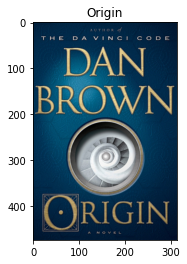

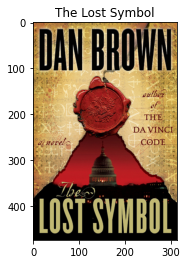

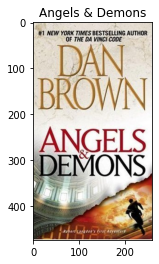

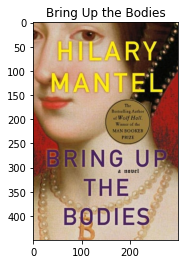

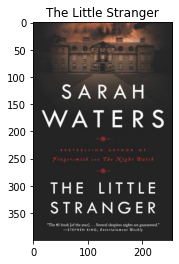

In [59]:
recommendations("The Da Vinci Code")

#### TF-IDF Word2Vec

In [40]:
#Building TFIDF model and calculate TFIDF score

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english')
tfidf.fit(df['cleaned'])

# Getting the words from the TF-IDF model

tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names() # tfidf words/col-names

E:\Modul Latihan\Bangkit\Capstone\Machine Learning\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
# Building TF-IDF Word2Vec 

# Storing the TFIDF Word2Vec embeddings
tfidf_vectors = []; 
line = 0;
# for each book description
for desc in corpus: 
  # Word vectors are of zero length (Used 300 dimensions)
    sent_vec = np.zeros(300) 
    # num of words with a valid vector in the book description
    weight_sum =0; 
    # for each word in the book description
    for word in desc: 
        if word in google_model.wv.key_to_index and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1

In [42]:
#Recommending top 5 similar books

def recommendations(title):
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)
    
    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

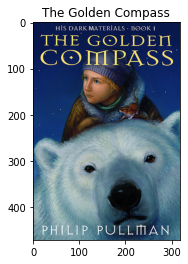

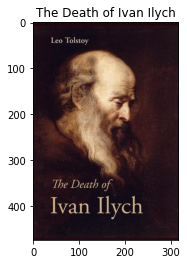

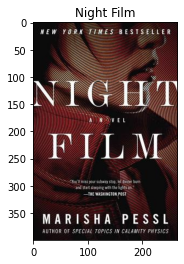

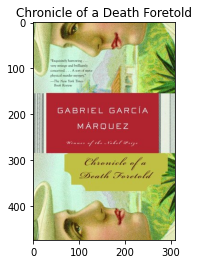

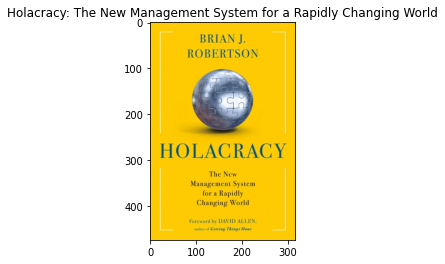

In [43]:
recommendations("The Murder of Roger Ackroyd")